# Barotropic gyre

In [1]:
using Oceananigans
using Oceananigans.Grids
using Oceananigans.Utils: prettytime, hours, day, days

using Oceananigans.Advection: EnergyConserving, EnstrophyConserving

using Oceananigans.Models.HydrostaticFreeSurfaceModels:
    HydrostaticFreeSurfaceModel,
    VectorInvariant,
    ExplicitFreeSurface,
    ImplicitFreeSurface

using Oceananigans.Units

using Statistics
using JLD2
using Printf

In [127]:
Nx = 128
Ny = 128

years = 365.25*days

# A spherical domain
underlying_grid = LatitudeLongitudeGrid(size = (Nx, Ny, 1),
                                        longitude = (-30, 30),
                                        latitude = (15, 75),
                                        z = (-4000, 0))

## bathymetry = zeros(Nx, Ny) .- 4000
## view(bathymetry, 31:34, 43:47) .= 0
## bathymetry = on_architecture(arch, bathymetry)
## grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bathymetry) )
grid = underlying_grid

free_surface = ImplicitFreeSurface(gravitational_acceleration=0.1)
# free_surface = ExplicitFreeSurface(gravitational_acceleration=0.1)

coriolis = HydrostaticSphericalCoriolis(scheme = EnstrophyConserving())

@show surface_wind_stress_parameters = (τ₀ = 1e-3,
                                        Lφ = grid.Ly,
                                        φ₀ = 15)

@inline surface_wind_stress(λ, φ, t, p) = p.τ₀ * cos(2π * (φ - p.φ₀) / p.Lφ)

surface_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress,
                                               parameters = surface_wind_stress_parameters)

μ = 1 / 60days

@inline u_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.u[i, j, 1]
@inline v_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.v[i, j, 1]

u_bottom_drag_bc = FluxBoundaryCondition(u_bottom_drag,
                                         discrete_form = true,
                                         parameters = μ)

v_bottom_drag_bc = FluxBoundaryCondition(v_bottom_drag,
                                         discrete_form = true,
                                         parameters = μ)

u_bcs = FieldBoundaryConditions(top = surface_wind_stress_bc,
                                bottom = u_bottom_drag_bc)

v_bcs = FieldBoundaryConditions(bottom = v_bottom_drag_bc)

@show const νh₀ = 5e3 * (60 / grid.Nx)^2

@inline νh(λ, φ, z, t) = νh₀ * cos(π * φ / 180)

variable_horizontal_diffusivity = HorizontalScalarDiffusivity(ν = νh)
constant_horizontal_diffusivity = HorizontalScalarDiffusivity(ν = νh₀)

model = HydrostaticFreeSurfaceModel(grid = grid,
                                    momentum_advection = VectorInvariant(),
                                    free_surface = free_surface,
                                    coriolis = coriolis,
                                    boundary_conditions = (u=u_bcs, v=v_bcs),
                                    closure = constant_horizontal_diffusivity,
                                    #closure = variable_horizontal_diffusivity,
                                    tracers = nothing,
                                    buoyancy = nothing)

g = model.free_surface.gravitational_acceleration

gravity_wave_speed = sqrt(g * grid.Lz) # hydrostatic (shallow water) gravity wave speed

# Time-scale for gravity wave propagation across the smallest grid cell
wave_propagation_time_scale = min(grid.radius * cosd(maximum(abs, grid.φᵃᶜᵃ)) * deg2rad(grid.Δλᶜᵃᵃ),
                                  grid.radius * deg2rad(grid.Δφᵃᶜᵃ)) / gravity_wave_speed

mutable struct Progress
    interval_start_time :: Float64
end

function (p::Progress)(sim)
    wall_time = (time_ns() - p.interval_start_time) * 1e-9

    @info @sprintf("Time: %s, iteration: %d, max(u): %.2e m s⁻¹, wall time: %s",
                   prettytime(sim.model.clock.time),
                   sim.model.clock.iteration,
                   maximum(sim.model.velocities.u),
                   prettytime(wall_time))

    p.interval_start_time = time_ns()

    return nothing
end

simulation = Simulation(model,
                        Δt = 3600,
                        stop_time = 1years)

simulation.callbacks[:progress] = Callback(Progress(time_ns()), IterationInterval(20))

output_fields = merge(model.velocities, (η=model.free_surface.η,))

output_prefix = "barotropic_gyre_Nx$(grid.Nx)_Ny$(grid.Ny)"

simulation.output_writers[:fields] = JLD2Writer(model, output_fields,
                                                schedule = TimeInterval(10day),
                                                filename = output_prefix,
                                                overwrite_existing = true)

surface_wind_stress_parameters = (τ₀ = 0.001, Lφ = grid.Ly, φ₀ = 15) = (τ₀ = 0.001, Lφ = 60.0, φ₀ = 15)
const νh₀ = 5000.0 * (60 / grid.Nx) ^ 2 = 1098.6328125


JLD2Writer scheduled on TimeInterval(10 days):
├── filepath: barotropic_gyre_Nx128_Ny128.jld2
├── 4 outputs: (u, v, w, η)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 62.4 KiB

In [ ]:
Nx = 128
Ny = 128

years = 365.25*days

# A spherical domain
underlying_grid = LatitudeLongitudeGrid(size = (Nx, Ny, 1),
                                        longitude = (-30, 30),
                                        latitude = (15, 75),
                                        z = (-4000, 0))

## bathymetry = zeros(Nx, Ny) .- 4000
## view(bathymetry, 31:34, 43:47) .= 0
## bathymetry = on_architecture(arch, bathymetry)
## grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bathymetry) )
grid = underlying_grid

free_surface = ImplicitFreeSurface(gravitational_acceleration=0.1)
# free_surface = ExplicitFreeSurface(gravitational_acceleration=0.1)

coriolis = HydrostaticSphericalCoriolis(scheme = EnstrophyConserving())

@show surface_wind_stress_parameters = (τ₀ = 1e-3,
                                        Lφ = grid.Ly,
                                        φ₀ = 15)

@inline surface_wind_stress(λ, φ, t, p) = p.τ₀ * cos(2π * (φ - p.φ₀) / p.Lφ)

surface_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress,
                                               parameters = surface_wind_stress_parameters)

μ = 1 / 60days

@inline u_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.u[i, j, 1]
@inline v_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.v[i, j, 1]

u_bottom_drag_bc = FluxBoundaryCondition(u_bottom_drag,
                                         discrete_form = true,
                                         parameters = μ)

v_bottom_drag_bc = FluxBoundaryCondition(v_bottom_drag,
                                         discrete_form = true,
                                         parameters = μ)

u_bcs = FieldBoundaryConditions(top = surface_wind_stress_bc,
                                bottom = u_bottom_drag_bc)

v_bcs = FieldBoundaryConditions(bottom = v_bottom_drag_bc)

@show const νh₀ = 5e3 * (60 / grid.Nx)^2

@inline νh(λ, φ, z, t) = νh₀ * cos(π * φ / 180)

variable_horizontal_diffusivity = HorizontalScalarDiffusivity(ν = νh)
constant_horizontal_diffusivity = HorizontalScalarDiffusivity(ν = νh₀)

model = HydrostaticFreeSurfaceModel(grid = grid,
                                    momentum_advection = VectorInvariant(),
                                    free_surface = free_surface,
                                    coriolis = coriolis,
                                    boundary_conditions = (u=u_bcs, v=v_bcs),
                                    closure = constant_horizontal_diffusivity,
                                    #closure = variable_horizontal_diffusivity,
                                    tracers = nothing,
                                    buoyancy = nothing)

g = model.free_surface.gravitational_acceleration

gravity_wave_speed = sqrt(g * grid.Lz) # hydrostatic (shallow water) gravity wave speed

# Time-scale for gravity wave propagation across the smallest grid cell
wave_propagation_time_scale = min(grid.radius * cosd(maximum(abs, grid.φᵃᶜᵃ)) * deg2rad(grid.Δλᶜᵃᵃ),
                                  grid.radius * deg2rad(grid.Δφᵃᶜᵃ)) / gravity_wave_speed

mutable struct Progress
    interval_start_time :: Float64
end

function (p::Progress)(sim)
    wall_time = (time_ns() - p.interval_start_time) * 1e-9

    @info @sprintf("Time: %s, iteration: %d, max(u): %.2e m s⁻¹, wall time: %s",
                   prettytime(sim.model.clock.time),
                   sim.model.clock.iteration,
                   maximum(sim.model.velocities.u),
                   prettytime(wall_time))

    p.interval_start_time = time_ns()

    return nothing
end

simulation = Simulation(model,
                        Δt = 3600,
                        stop_time = 1years)

simulation.callbacks[:progress] = Callback(Progress(time_ns()), IterationInterval(20))

output_fields = merge(model.velocities, (η=model.free_surface.η,))

output_prefix = "barotropic_gyre_Nx$(grid.Nx)_Ny$(grid.Ny)"

simulation.output_writers[:fields] = JLD2Writer(model, output_fields,
                                                schedule = TimeInterval(10day),
                                                filename = output_prefix,
                                                overwrite_existing = true)

In [128]:
run!(simulation)

[ Info: Initializing simulation...
[ Info: Time: 0 seconds, iteration: 0, max(u): 0.00e+00 m s⁻¹, wall time: 4.393 seconds
[ Info:     ... simulation initialization complete (2.428 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.250 seconds).
[ Info: Time: 20 hours, iteration: 20, max(u): 2.73e-03 m s⁻¹, wall time: 3.807 seconds
[ Info: Time: 1.667 days, iteration: 40, max(u): 3.73e-03 m s⁻¹, wall time: 105.017 ms
[ Info: Time: 2.500 days, iteration: 60, max(u): 3.94e-03 m s⁻¹, wall time: 103.802 ms
[ Info: Time: 3.333 days, iteration: 80, max(u): 3.28e-03 m s⁻¹, wall time: 105.145 ms
[ Info: Time: 4.167 days, iteration: 100, max(u): 9.42e-03 m s⁻¹, wall time: 104.331 ms
[ Info: Time: 5 days, iteration: 120, max(u): 2.84e-02 m s⁻¹, wall time: 115.727 ms
[ Info: Time: 5.833 days, iteration: 140, max(u): 4.74e-02 m s⁻¹, wall time: 103.593 ms
[ Info: Time: 6.667 days, iteration: 160, max(u): 6.51e-02 m s⁻¹, wall time: 104.088 ms
[ Info: Time: 

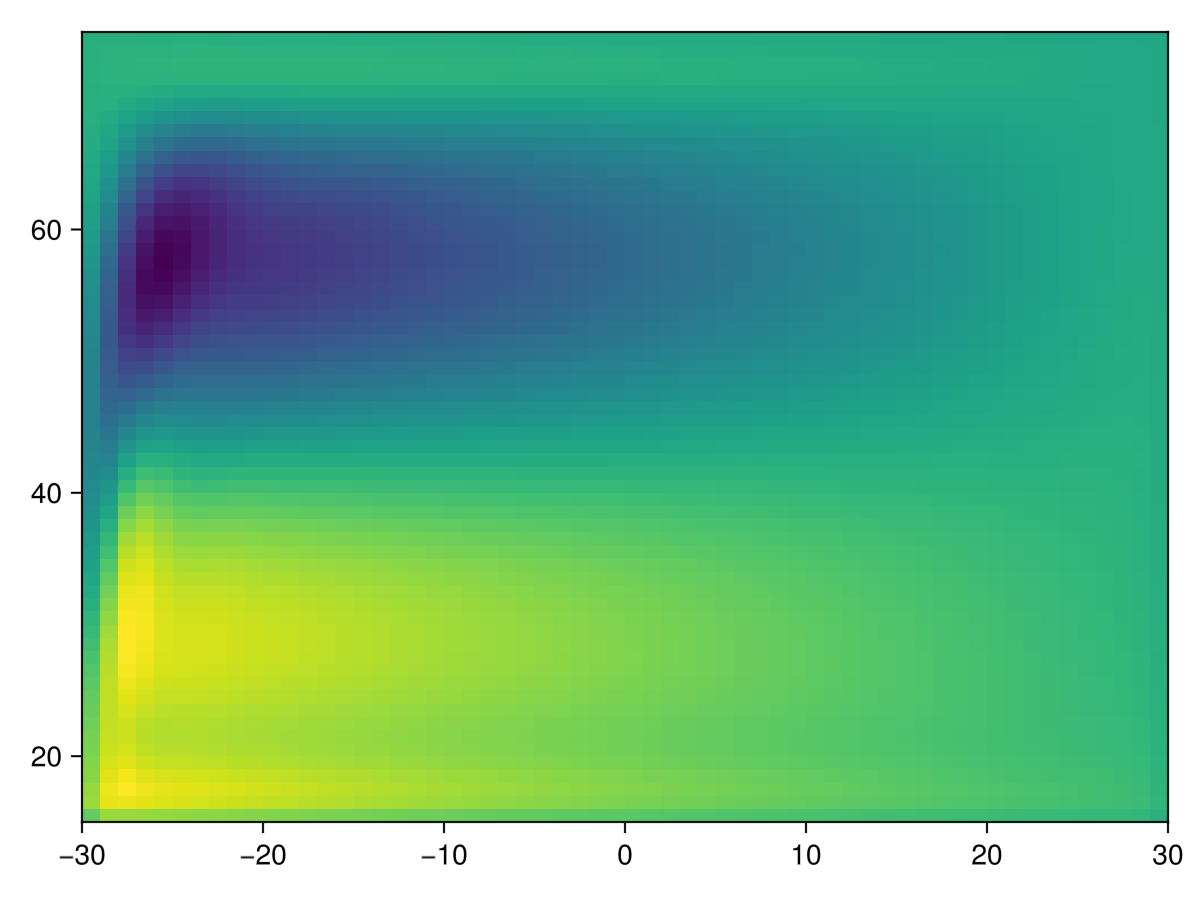

In [130]:
η = FieldTimeSeries("barotropic_gyre_Nx60_Ny60.jld2", "η")

x, y, z = nodes(η)
heatmap(x[:], y[:], interior(η)[:,:,1,30])

In [103]:
using GLMakie

function geographic2cartesian(λ, φ, r=1)
    Nλ = length(λ)
    Nφ = length(φ)

    λ = repeat(reshape(λ, Nλ, 1), 1, Nφ) 
    φ = repeat(reshape(φ, 1, Nφ), Nλ, 1)

    λ_azimuthal = λ .+ 180  # Convert to λ ∈ [0°, 360°]
    φ_azimuthal = 90 .- φ   # Convert to φ ∈ [0°, 180°] (0° at north pole)

    x = @. r * cosd(λ_azimuthal) * sind(φ_azimuthal)
    y = @. r * sind(λ_azimuthal) * sind(φ_azimuthal)
    z = @. r * cosd(φ_azimuthal)

    return x, y, z
end

function visualize_barotropic_gyre(filepath)

    file = jldopen(filepath)

    Nx = file["grid/Nx"]
    Ny = file["grid/Ny"]

    # A spherical domain
    grid = LatitudeLongitudeGrid(size = (Nx, Ny, 1),
                                 longitude = (-30, 30),
                                 latitude = (15, 75),
                                 z = (-4000, 0))

    iterations = parse.(Int, keys(file["timeseries/t"]))

    xu, yu, zu = geographic2cartesian(xnodes(grid, Face(), Center())  , ynodes(grid, Center()))
    xv, yv, zv = geographic2cartesian(xnodes(grid, Center(), Face())  , ynodes(grid, Center()))
    xc, yc, zc = geographic2cartesian(xnodes(grid, Center(), Center()), ynodes(grid, Center()))

    iter = Observable(0)

    plot_title = @lift @sprintf("Barotropic gyre: time = %s", prettytime(file["timeseries/t/" * string($iter)]))

    u = @lift file["timeseries/u/" * string($iter)][:, :, 1]
    v = @lift file["timeseries/v/" * string($iter)][:, :, 1]
    η = @lift file["timeseries/η/" * string($iter)][:, :, 1]

    fig = Figure(size=(2160, 1080))

    x = (xu, xv, xc)
    y = (yu, yv, yc)
    z = (zu, zv, zc)

    statenames = ["u", "v", "η"]
    for (n, var) in enumerate([u, v, η])
        ax = fig[3:7, 3n-2:3n] = LScene(fig) # make plot area wider
        wireframe!(ax, Sphere(Point3f(0), 0.99f0))
        surface!(ax, x[n], y[n], z[n], color=var, colormap=:balance) #, colorrange=clims[n])
        rotate_cam!(ax.scene, (0, 3π/4, 0))
        fig[2, 2 + 3*(n-1)] = Label(fig, statenames[n], fontsize = 50) # put names in center
    end

    supertitle = fig[0, :] = Label(fig, plot_title, fontsize=50)

    record(fig, output_prefix * ".mp4", iterations, framerate=30) do i
        @info "Animating iteration $i/$(iterations[end])..."
        iter[] = i
    end

    close(file)

    return nothing
end

visualize_barotropic_gyre (generic function with 1 method)

In [118]:
grid.λᶜᵃᵃ[1:end-3]

-29.5:1.0:29.5

In [122]:
u = file["timeseries/u/0"][:, :, 1]

67×66 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [102]:
visualize_barotropic_gyre(string(output_prefix, ".jld2"))

[ Info: Animating iteration 0/8640...
[ Info: Animating iteration 240/8640...
[ Info: Animating iteration 480/8640...
[ Info: Animating iteration 720/8640...
[ Info: Animating iteration 960/8640...
[ Info: Animating iteration 1200/8640...
[ Info: Animating iteration 1440/8640...
[ Info: Animating iteration 1680/8640...
[ Info: Animating iteration 1920/8640...
[ Info: Animating iteration 2160/8640...
[ Info: Animating iteration 2400/8640...
[ Info: Animating iteration 2640/8640...
[ Info: Animating iteration 2880/8640...
[ Info: Animating iteration 3120/8640...
[ Info: Animating iteration 3360/8640...
[ Info: Animating iteration 3600/8640...
[ Info: Animating iteration 3840/8640...
[ Info: Animating iteration 4080/8640...
[ Info: Animating iteration 4320/8640...
[ Info: Animating iteration 4560/8640...
[ Info: Animating iteration 4800/8640...
[ Info: Animating iteration 5040/8640...
[ Info: Animating iteration 5280/8640...
[ Info: Animating iteration 5520/8640...
[ Info: Animating itera